<a href="https://colab.research.google.com/github/eeolga/deep/blob/main/Logs_data5_xls_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
logs_path = '/content/logs_5_xls.xlsx'
data = pd.read_excel(logs_path)

In [3]:
display(pd.DataFrame(data))

,ID,Spec,MotherTongue,Gender,Age,Activity,DayPart,Lesson,Grade
0,29292,1,1,0,20,23,3,1,5
1,26864,2,0,1,22,7,3,0,0
2,26861,2,0,1,21,18,1,1,3
3,26760,3,1,0,22,8,1,1,5
4,26544,4,1,1,21,9,1,1,5
5,29598,11,1,1,25,7,1,1,0
6,29133,1,1,1,20,14,1,1,5
7,26604,2,0,1,23,6,1,1,4
8,29346,1,1,1,20,4,1,1,5
9,26563,4,1,1,21,14,1,1,4


In [4]:
X = data.drop('Grade', axis=1).values
y = data['Grade'].values

In [16]:
# Ensure target values are 0 or 1
y = (y == 1).astype(float)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [19]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [20]:
#  Define the Model
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(input_dim, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.sigmoid(self.layer3(x))
        return x

input_dim = X_train.shape[1]
model = SimpleNN(input_dim)

In [21]:
# Define Loss Function and Optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [34]:
# Train the Model
num_epochs = 100
loss_values = []

for epoch in range(num_epochs):
    model.train()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_values.append(loss.item())

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.0006
Epoch [20/100], Loss: 0.0005
Epoch [30/100], Loss: 0.0004
Epoch [40/100], Loss: 0.0003
Epoch [50/100], Loss: 0.0002
Epoch [60/100], Loss: 0.0002
Epoch [70/100], Loss: 0.0001
Epoch [80/100], Loss: 0.0001
Epoch [90/100], Loss: 0.0001
Epoch [100/100], Loss: 0.0001


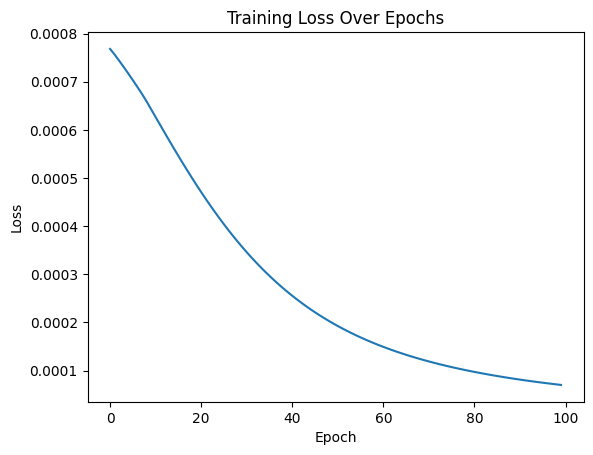

In [35]:
# Plot the loss
import matplotlib.pyplot as plt
plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

In [37]:
# Evaluate the Model
model.eval()
with torch.no_grad():
    y_predicted = model(X_test)
    y_predicted = y_predicted.round()
    accuracy = (y_predicted.eq(y_test).sum() / float(y_test.shape[0])).item()
    print(f'Accuracy: {accuracy:.4f}')

Accuracy: 1.0000


In [38]:
# Example of precision, recall calculation using the previously defined approach:
predicted_indexes = (y_predicted == 1)
actual_indexes = (y_test == 1)

In [39]:
n_predicted = torch.sum(predicted_indexes).item()
n_actual = torch.sum(actual_indexes).item()
n_matches = torch.sum(predicted_indexes & actual_indexes).item()

In [40]:
precision = n_matches / n_predicted if n_predicted else 0
recall = n_matches / n_actual if n_actual else 0

In [41]:
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

Precision: 0.0000
Recall: 0.0000


The model is not correctly identifying any positive instances—problems with the data, the model architecture, the training process, or the evaluation logic.

In [42]:
# Print some model predictions and corresponding actual values
with torch.no_grad():
    outputs = model(X_test)
    print(outputs[:10])  # Print first 10 predictions
    print(y_test[:10])  # Print first 10 actual values

tensor([[8.4030e-06],
        [1.9479e-04],
        [5.8985e-10],
        [8.9973e-05]])
tensor([[0.],
        [0.],
        [0.],
        [0.]])


The default threshold for classifying a binary prediction is 0.5. If the model's predictions are not well-calibrated, we need to adjust this threshold.

In [43]:
import matplotlib.pyplot as plt

# Assuming you have stored loss values in a list
loss_values = []

for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_values.append(loss.item())
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.0001
Epoch [20/100], Loss: 0.0001
Epoch [30/100], Loss: 0.0000
Epoch [40/100], Loss: 0.0000
Epoch [50/100], Loss: 0.0000
Epoch [60/100], Loss: 0.0000
Epoch [70/100], Loss: 0.0000
Epoch [80/100], Loss: 0.0000
Epoch [90/100], Loss: 0.0000
Epoch [100/100], Loss: 0.0000


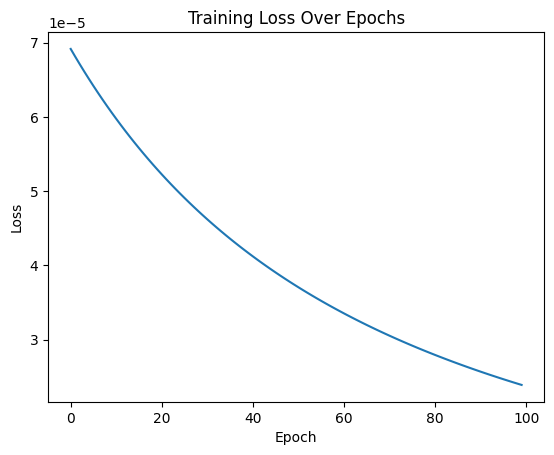

In [44]:
# Plot the loss
plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

The accuracy and completeness of the model are zero.
Adjustments to improve its performance:
- check that the data is balanced and correctly preprocessed,
- check and confirm the model output,
- adjust training parameters.